## Analysis of  StarTracker Pointing and Tracking Test - Slew and Settle - 

### Jitter 

Full test description at: https://sitcomtn-063.lsst.io/

In this notebook, we quantify the telescope jitter after settle to a coordinate.

For this:
1. We compute the standard deviation of $\delta ra \text{, } \delta dec$
2. Does the jitter depends on $ra, dec$?

To visualize this correlations see: \
`LVV-T2732_analysis.ipynb`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function to read in the metadata that has been downloaded
import pandas as pd
def read_rubintv(fname):
    df = pd.read_json(fname).T
    df = df.dropna()
    times = df[['UTC','UTC wide']]
    
    df = df.drop(columns=['UTC','UTC wide'])
    df = df.astype(float)
    
    # set time vectors
    timenew = (today+'T'+ times['UTC'].to_numpy()).astype(np.datetime64)
    timenew2= (today+'T'+ times['UTC wide'].to_numpy()).astype(np.datetime64)
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [3]:
def get_groups(df):
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    groups = np.zeros(ra.size, dtype=int)
    snakes = np.zeros(ra.size, dtype=int)
    
    diffRa = np.diff(ra)
    diffDec = np.diff(dec)
    dPnt = np.hypot(diffDec, diffRa)
    
    counter = 0
    for i in range(diffRa.size):
        if  (dPnt[i]>5.): counter += 1
        snakes[i+1] = counter

    counter = 0
    for i in range(diffRa.size):
        if  (dPnt[i]>1/60)&(dPnt[i]<5.): counter += 1
        groups[i+1] = counter

    df['groups'] = groups
    df['snakes'] = snakes
    
    print('Number of Snakes:%i'%np.unique(snakes).size)
    return df

In [4]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y):
    isnan = np.isnan(x)
    coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    return np.append(coefs, np.sqrt(cov[1,1]))

def get_residual(df):    
    groups = df['groups'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    for ix in keys:
        #base_ra[ix] = ra[ix][0]
        #base_dec[ix] = dec[ix][0]
        
        base_ra[ix] = np.median(ra[ix])
        base_dec[ix] = np.median(dec[ix])
    
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600
    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    
    return res_ra, res_dec, base_ra, base_dec

In [5]:
# read in dataframe
today = '2023-03-09'
fname = 'startracker_%s.json'%today
df = read_rubintv(fname)

In [6]:
df

,Exposure Time wide,MJD wide,Ra wide,Dec wide,Alt wide,Az wide,Exposure Time,MJD,Ra,Dec,...,Delta Ra Arcsec wide,Delta Dec Arcsec wide,Delta Alt Arcsec wide,Delta Az Arcsec wide,Delta Rot Arcsec wide,RMS scatter arcsec wide,RMS scatter pixels wide,UTC,UTC wide,seq_num
2,5.0,60013.006804,147.584927,-20.755174,45.438896,89.573966,4.0,60013.006798,147.584931,-20.755208,...,-2.709905,-59.325366,-673.488731,1095.555919,1.050384e+06,4.412145,0.509349,2023-03-09 00:09:47,2023-03-09 00:09:47,2
5,5.0,60013.007130,147.584990,-20.755174,45.540590,89.513847,4.0,60013.007125,147.584996,-20.755208,...,-2.533244,-59.268129,-673.513094,1097.478513,1.050382e+06,4.406446,0.508694,2023-03-09 00:10:15,2023-03-09 00:10:16,5
6,5.0,60013.007241,147.585035,-20.755209,45.575238,89.493390,4.0,60013.007235,147.585052,-20.755174,...,-2.272147,-59.337748,-674.354962,1098.767723,1.050381e+06,4.435253,0.512020,2023-03-09 00:10:25,2023-03-09 00:10:25,6
7,5.0,60013.007349,147.585093,-20.755174,45.608984,89.473347,4.0,60013.007344,147.585062,-20.755174,...,-2.399532,-59.612528,-673.967859,1099.639064,1.050380e+06,4.417225,0.509938,2023-03-09 00:10:34,2023-03-09 00:10:34,7
8,5.0,60013.007459,147.585099,-20.755174,45.643181,89.453082,4.0,60013.007453,147.585028,-20.755174,...,-2.232958,-59.515211,-674.091351,1100.229944,1.050380e+06,4.396507,0.507552,2023-03-09 00:10:43,2023-03-09 00:10:44,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,5.0,60013.341335,286.946784,-40.029897,35.148083,119.955272,4.0,60013.341329,286.946813,-40.029897,...,28.794702,-59.257096,8.503464,77.053017,1.087482e+06,4.571916,0.527515,2023-03-09 08:11:30,2023-03-09 08:11:31,1794
1795,5.0,60013.341657,299.482152,-37.240831,25.063850,119.968851,4.0,60013.341651,299.482122,-37.240831,...,-1.838682,-67.940286,45.332494,69.275972,1.059507e+06,8.415523,0.971061,2023-03-09 08:11:58,2023-03-09 08:11:59,1795
1796,5.0,60013.341759,299.482205,-37.240776,25.091362,119.957704,4.0,60013.341753,299.482194,-37.240776,...,-1.841248,-67.890959,45.530605,69.120542,1.059572e+06,8.302773,0.958069,2023-03-09 08:12:07,2023-03-09 08:12:07,1796
1797,5.0,60013.341861,299.482056,-37.240829,25.119192,119.946550,4.0,60013.341856,299.482116,-37.240803,...,-1.214643,-67.748997,44.917572,69.228530,1.059633e+06,8.239899,0.950826,2023-03-09 08:12:16,2023-03-09 08:12:16,1797


In [7]:
sequences = [ [600,646],  [646,946],  [949,982], [983,1115]]
# sequences = [ [600,643] ]
# sequences = [ [679,712] ]
# sequences = [ [600,646],  [646,910]]
indices = np.empty((0,),dtype=int)

for i0, ie in sequences:
    indices = np.append(indices, np.arange(i0,ie,1,dtype=int))
indices[::5]

array([ 600,  605,  610,  615,  620,  625,  630,  635,  640,  645,  650,
        655,  660,  665,  670,  675,  680,  685,  690,  695,  700,  705,
        710,  715,  720,  725,  730,  735,  740,  745,  750,  755,  760,
        765,  770,  775,  780,  785,  790,  795,  800,  805,  810,  815,
        820,  825,  830,  835,  840,  845,  850,  855,  860,  865,  870,
        875,  880,  885,  890,  895,  900,  905,  910,  915,  920,  925,
        930,  935,  940,  945,  953,  958,  963,  968,  973,  978,  984,
        989,  994,  999, 1004, 1009, 1014, 1019, 1024, 1029, 1034, 1039,
       1044, 1049, 1054, 1059, 1064, 1069, 1074, 1079, 1084, 1089, 1094,
       1099, 1104, 1109, 1114])

In [8]:
# selection of the sequences
data = df.iloc[indices].reset_index() 
print(('Positions for ' + str(data.seq_num.iloc[0]) + ' to ' + str(data.seq_num.iloc[-1])))
first_attempt_circle = get_groups(data)

Positions for 621 to 1137
Number of Snakes:25


In [9]:
# check groups
# each group should have 3 exposures
_, _, counts = np.unique(data['groups'].to_numpy(), return_index=True, return_counts=True)
counts

array([ 4,  4,  4,  3,  4,  4,  4,  3,  4,  4, 11,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  3,
        3,  9,  3,  3,  3,  3,  3, 18,  3,  9,  3, 12,  3,  3,  3,  3,  3,
        3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  3,  6,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3])

In [10]:
# mask = (counts==3)|(counts==4)
# np.unique(snakes, return_counts=True)

In [11]:
res_ra, res_dec, base_ra, base_dec = get_residual(data)

snakes = data['snakes'].to_numpy()
keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]
keys[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

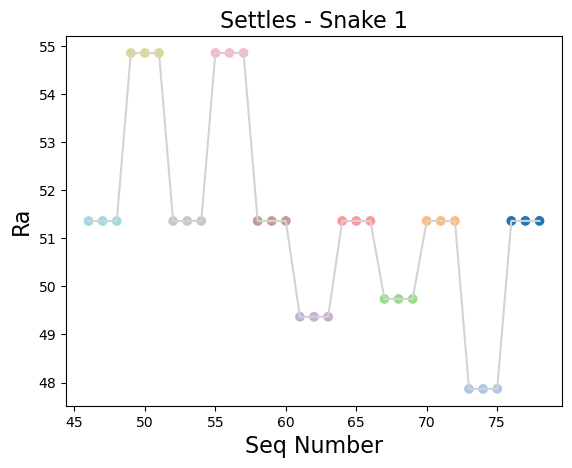

In [12]:
snake_id = 1
ix = keys[snake_id]
data['Calculated Ra wide'].iloc[ix].plot(color='lightgray')
plt.scatter(data.iloc[ix].index, data['Calculated Ra wide'].iloc[ix], 
            c=data['groups'].iloc[ix], cmap='tab20_r')

plt.title('Settles - Snake %i'%snake_id, fontsize=16)
plt.ylabel('Ra', fontsize=16)
plt.xlabel('Seq Number', fontsize=16)
plt.savefig('pointing_ra.png',dpi=100)

For each group (setlle point), I subtract the median (RA,DEC). The residuals are basically the telescope jitter.

In [13]:
base_alt = data['Calculated Alt wide'].to_numpy()
base_az = data['Calculated Az wide'].to_numpy()
snakes = data['snakes'].to_numpy()

# base_az = np.where(base_az>180, 180-base_az, base_az)
# base_ra = np.where(base_ra>180, 180-base_ra, base_ra)

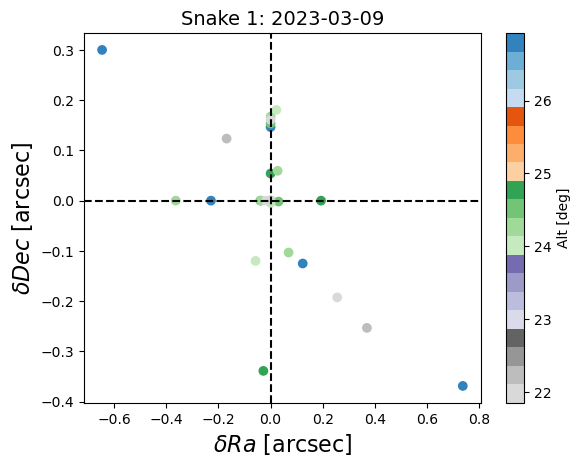

In [14]:
plt.scatter(res_ra[ix], res_dec[ix], c=base_alt[ix],cmap='tab20c_r')
plt.axvline(0,color='k',ls='--')
plt.axhline(0,color='k',ls='--')
plt.title('Snake %i: 2023-03-09'%snake_id,fontsize=14)
plt.xlabel(r'$\delta Ra$ [arcsec]',fontsize=16)
plt.ylabel(r'$\delta Dec$ [arcsec]',fontsize=16)
plt.colorbar(label='Alt [deg]')
plt.savefig('residual_radec.png',dpi=100)

We see a typical jitter amplitude of $0.5$ arcsec with some outliers.

In [15]:
def get_sigma_68(x):
    p16, p84 = np.nanpercentile(x, [16,84])
    return (p84-p16)/2.

def get_jitter(ra,dec):
    jra = get_sigma_68(ra)
    jdec = get_sigma_68(dec)
    return np.array([jra, jdec, np.hypot(jra,jdec)])

In [16]:
# Now I will compute the standard deviation (\sigma_{68}) for each snake

stds = []
for ix in keys:
    stds.append(get_jitter(res_ra[ix],res_dec[ix]))
stds = np.array(stds)

/Users/jesteves/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


In [17]:
_, sids, counts = np.unique(data['snakes'].to_numpy(), return_index=True, return_counts=True)
counts

array([46, 33, 33, 33, 33, 33, 33, 33, 33, 33, 12,  3, 21,  3,  3,  3,  3,
        9,  3,  9,  3,  3, 27, 33, 33])

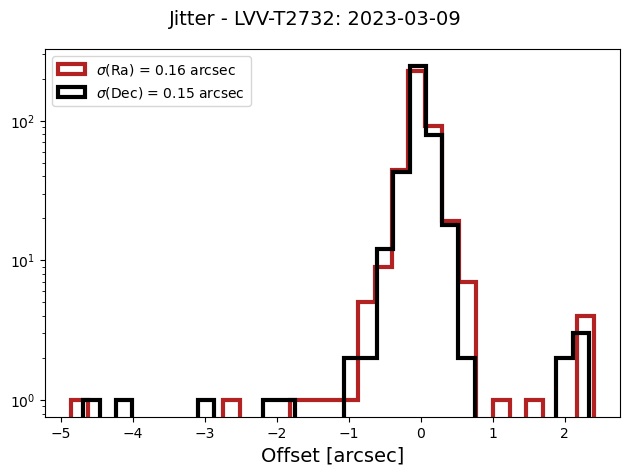

In [19]:
jra = get_sigma_68(res_ra)
jdec = get_sigma_68(res_dec)

_ = plt.hist(res_ra, bins=31, color='firebrick', histtype='step', lw=3, label='$\sigma$(Ra) = %.2f arcsec'%jra)
_ = plt.hist(res_dec, bins=31, color='k', histtype='step', lw=3, label='$\sigma$(Dec) = %.2f arcsec'%jdec)
plt.yscale('log')
plt.legend(loc=2)
plt.xlabel('Offset [arcsec]', fontsize=14)
plt.suptitle('Jitter - LVV-T2732: 2023-03-09',fontsize=14)
plt.tight_layout()
plt.savefig('jitter_histogram.png',dpi=100)

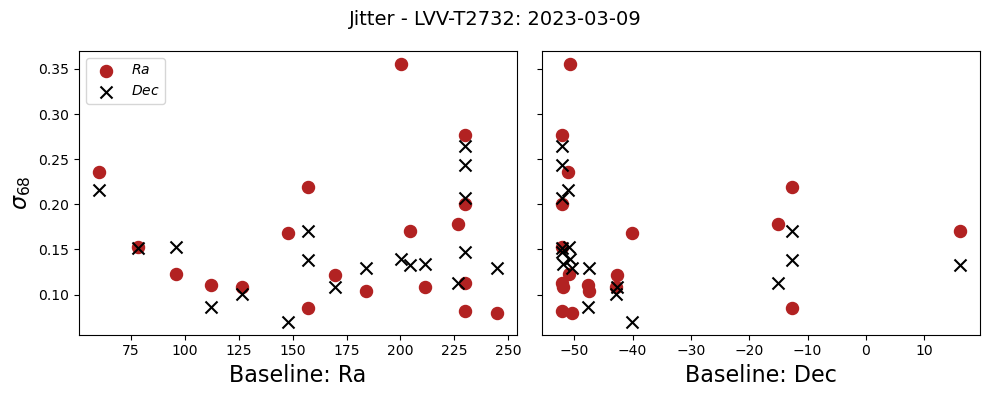

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax1.scatter(base_ra[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_dec[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_ra[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_dec[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=2)
# ax1.errorbar(base_ra[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')
# ax2.errorbar(base_dec[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Ra',fontsize=16)
ax2.set_xlabel('Baseline: Dec',fontsize=16)
fig.suptitle('Jitter - LVV-T2732: 2023-03-09',fontsize=14)
fig.tight_layout()
plt.savefig('jitter_radec.png',dpi=100)

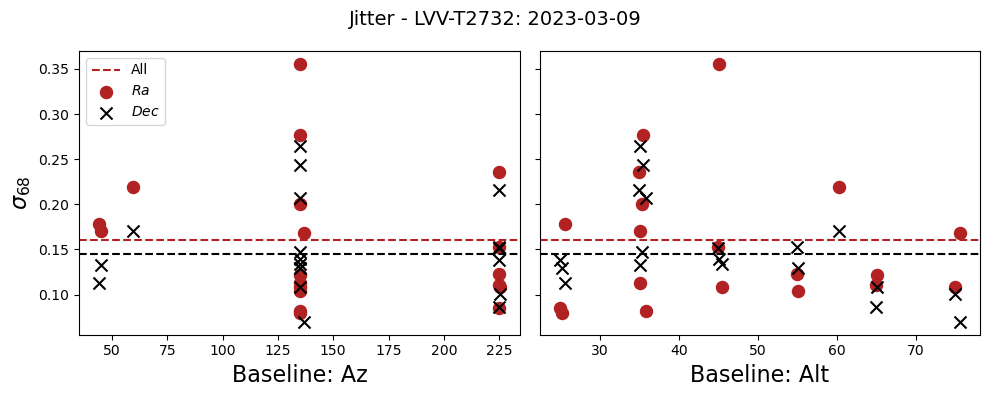

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax2.axhline(jra, c='firebrick', ls='--')
ax2.axhline(jdec, c='k', ls='--')

ax1.axhline(jra, c='firebrick', ls='--',label='All')
ax1.axhline(jdec, c='k', ls='--')

ax1.scatter(base_az[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_alt[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_az[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_alt[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=2)
# ax2.legend(loc=1)

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Az',fontsize=16)
ax2.set_xlabel('Baseline: Alt',fontsize=16)
fig.suptitle('Jitter - LVV-T2732: 2023-03-09',fontsize=14)
fig.tight_layout()
plt.savefig('jitter_azalt.png',dpi=100)